Certo, irei anotar aqui como estou pensando em resolver esse problema. Primeiro, a gente precisa entender qual é o perfil do público que já utiliza o laboratório — faixa etária, gênero, quanto costumam gastar e renda média. Com essas informações em mãos, a ideia é buscar bairros ou cidades com características semelhantes, mas onde o laboratório ainda não atua. A partir disso, conseguimos identificar as melhores opções para expansão.

Para começar vou importar as bibliotecas, e tbm irei adicionar um pip install para garantir que tudo será instalado corretamente.

In [2]:
# Aqui será feita a importação de todas as bibliotecas utilizadas no código

%pip install pandas unidecode numpy geopandas matplotlib seaborn statsmodels geopy folium

import pandas as pd
from unidecode import unidecode
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.api as sm
from geopy.geocoders import Nominatim




Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Agora irei importar as tabelas, mas antes - percebi que alguns arquivos estavam com sufixos como “(1)” no nome. Esses sufixos, além de poluir o nome do arquivo, podem gerar confusão na hora de automatizar processos, como leitura em lote ou iteração por nomes de arquivos. 

No primeiro momento, para garantir consistência na nomenclatura e facilitar a manipulação dos datasets ao longo da análise, pensei em renomeá-los com identificadores mais limpos e padronizados.

Porém como vcs podem querer limpar minha base de dados para realizar o teste, pois já tem arquivos modificados e outros gerados e para evitar dor de cabeça para vcs deixei nesse formato. 

In [142]:
#Importando arquivos csv necessários para o funcionamento do código e transformando em data frames

demo_df = pd.read_csv('DemographicData_ZCTAs.csv');
geocode_df = pd.read_csv('df_geocode (1).csv');
economic_df = pd.read_csv('EconomicData_ZCTAs (1).csv');
exams_data_df = pd.read_csv('exams_data.csv');
transactional_data_df = pd.read_csv('transactional_data (1).csv', delimiter=';');

In [4]:
#Procurando se algum desses DFs apresentam dados duplicados

print(demo_df.duplicated().value_counts())
print(geocode_df.duplicated().value_counts())
print(economic_df.duplicated().value_counts())
print(exams_data_df.duplicated().value_counts())
print(transactional_data_df.duplicated().value_counts())

False    33120
Name: count, dtype: int64
False    119
Name: count, dtype: int64
False    629280
Name: count, dtype: int64
False    2002
Name: count, dtype: int64
False    2340722
True       14519
Name: count, dtype: int64


Percebi que a penúltima linha cosnta que tem duplicada, então vou remover pra deixar os dados mais limpos e evitar problemas na análise.

In [5]:
#Remove as linhas duplicadas em transactional_data_df

transactional_data_df = transactional_data_df.drop_duplicates()
print(transactional_data_df.duplicated().value_counts())

False    2340722
Name: count, dtype: int64


Depois de explorar os DataFrames, cheguei à conclusão de que os dados do transactional são os mais relevantes para identificar o perfil dos clientes que frequentam o laboratório. E como cheguei a esse ponto? 

Justamente por ser uma análise de segmentação, acredito que seja mais eficiente consolidar os gastos por visita — ou seja, ao invés de manter várias entradas para cada teste realizado em uma mesma visita, posso calcular o total gasto naquela ocasião. Isso simplifica a análise e ainda fornecer uma métrica relevante de comportamento de consumo.

Notei que as colunas estão todas bagunçadas, então a seguir irei fazer o tratamento das colunas que estão com espaços vazios, nomes maiusculos/minusculo e acentos. 

Como usar snake_case é uma das melhores práticas para nomes de colunas em projetos de dados, farei uma função usando df.columns = [...] para deixar no formato com tudo minusculo com as palavras separadas por "_".

In [7]:
# Função pra transformar o código em snake case

from unidecode import unidecode #ta dando erro aqui

def padronizar_nomes_colunas(df):
    df.columns = [
        unidecode(col).strip().replace(" ", "_").lower()
        for col in df.columns
    ]

# Aplicando a padronização em todos os DataFrames

dfs = [demo_df, economic_df, geocode_df, exams_data_df, transactional_data_df]    

for df in dfs:
    padronizar_nomes_colunas(df)

Optei por usar o df.columns = [...] em vez de rename(...) pq evita repetição e melhora a escalabilidade, se amanhã por exemplo, for preciso colocar 10 DFs, só adiciona ali em dfs = [...] 

In [ ]:
# Vou conferir se os dados estão com os tipos corretos.

print(transactional_data_df.dtypes)

patient_id         object
gender             object
date_of_birth      object
date_of_service    object
service_id         object
lab_id             object
coditem             int64
testing_cost       object
dtype: object


In [11]:
# Agora vou verificando se há registros com valores nulos no DataFrame
linhas_com_valores_nulos = transactional_data_df[transactional_data_df.isnull().any(axis=1)]

# Esse trecho nos permiti ver quais linhas possuem pelo menos um valor nulo
print("Linhas com dados faltantes:")
print(linhas_com_valores_nulos)

Linhas com dados faltantes:
           patient_id gender date_of_birth date_of_service      service_id  \
1253947  7659985004-1      F           NaN      2020-02-22  7659985004-2-1   

        lab_id   coditem testing_cost  
1253947   L152  70000107         48,0  


Como nesse caso identifiquei que a linha com índice 1253947 tem valor nulo, pretendo removê-la.

In [12]:
# Remove a linha

transactional_data_df = transactional_data_df.drop(index=1253947)

Continuando no processo de tratar os tipos de dados, vou tratar datas e valores monetários para que o transactional_data_df e exams_data_df fiquem prontos para análise, agregações, visualizações e modelagem.

In [15]:
# Convertendo colunas de identificadores e categorias para string

transactional_data_df['patient_id'] = transactional_data_df['patient_id'].astype(str)
transactional_data_df['gender'] = transactional_data_df['gender'].astype(str)
transactional_data_df['service_id'] = transactional_data_df['service_id'].astype(str)
transactional_data_df['lab_id'] = transactional_data_df['lab_id'].astype(str)
transactional_data_df['coditem'] = transactional_data_df['coditem'].astype(str)
exams_data_df['coditem'] = exams_data_df['coditem'].astype(str)

# Convertendo data de nascimento com hora para datetime

transactional_data_df['date_of_birth'] = pd.to_datetime(transactional_data_df['date_of_birth'], format="%d/%m/%Y %H:%M:%S")
transactional_data_df['date_of_birth'] = transactional_data_df['date_of_birth'].dt.date
transactional_data_df['date_of_birth'] = pd.to_datetime(transactional_data_df['date_of_birth'], format="%Y-%m-%d")
transactional_data_df['date_of_service'] = pd.to_datetime(transactional_data_df['date_of_service'], format="%Y-%m-%d")

# Convertendo data de nascimento com hora para datetime

transactional_data_df['testing_cost'] = transactional_data_df['testing_cost'].replace(',', '.').astype(float)
transactional_data_df['testing_cost'] = transactional_data_df['testing_cost'].astype(float)

In [ ]:
# Exibe os tipos de dados (dtypes) de cada coluna do DataFrame 'transactional_data_df'

print(transactional_data_df.dtypes)


patient_id                 object
gender                     object
date_of_birth      datetime64[ns]
date_of_service    datetime64[ns]
service_id                 object
lab_id                     object
coditem                    object
testing_cost              float64
dtype: object


In [ ]:
# Exibe as primeiras 5 linhas do DataFrame 'transactional_data_df' para uma visualização inicial dos dados

transactional_data_df.head()


,patient_id,gender,date_of_birth,date_of_service,service_id,lab_id,coditem,testing_cost
0,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70003237,9.0
1,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000638,13.0
2,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001597,49.0
3,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000103,11.0
4,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000224,10.0


In [19]:
# Calcula a idade aproximada do paciente em anos com base na diferença entre a data de atendimento e a data de nascimento
transactional_data_df['age'] = (transactional_data_df['date_of_service'] - transactional_data_df['date_of_birth']).dt.days // 365

# Converte a coluna 'age' para o tipo inteiro (int), removendo possíveis decimais
transactional_data_df['age'] = transactional_data_df['age'].astype(int)

# Exibe as primeiras 15 linhas do DataFrame para verificar o resultado da nova coluna 'age'
transactional_data_df.head(15)


,patient_id,gender,date_of_birth,date_of_service,service_id,lab_id,coditem,testing_cost,age
0,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70003237,9.0,42
1,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000638,13.0,42
2,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001597,49.0,42
3,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000103,11.0,42
4,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000224,10.0,42
5,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70002653,8.0,42
6,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001206,41.0,42
7,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70005903,57.0,42
8,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000392,8.0,42
9,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000168,48.0,42


Quero entender a distribuição de gênero, acho importante entender o que está vindo nos dados antes de seguir com qualquer análise mais profunda. 

In [20]:
# Exibe a contagem de ocorrências para cada valor distinto na coluna 'gender'.

transactional_data_df["gender"].value_counts()


gender
F    1491029
M     849683
I          9
Name: count, dtype: int64

Notei que a maioria dos atendimentos são feitos por mulheres, o que é uma informação interessante.


In [21]:
# Agora vou remover as linhas em que o gênero está marcado como "I", pois esse valor não representa um gênero válido para a análise.

transactional_data_df = transactional_data_df[transactional_data_df["gender"] != "I"]


In [22]:
# Aqui estou analisando a distribuição da idade para identificar possíveis inconsistências, como valores muito baixos ou altos demais

transactional_data_df["age"].describe()


count    2.340712e+06
mean     4.149545e+01
std      1.747037e+01
min      0.000000e+00
25%      3.000000e+01
50%      4.200000e+01
75%      5.400000e+01
max      1.590000e+02
Name: age, dtype: float64

Me chamou atenção o fato da idade máxima ser 159 anos, então quero investigar melhor os registros com idade igual ou superior a 100.


In [23]:
# Identificação de possíveis outliers: filtrando registros com idade igual ou superior a 100 anos para avaliar a validade desses dados

print(transactional_data_df[transactional_data_df["age"] >= 100])


                  patient_id gender date_of_birth date_of_service  \
10476     10240389069-BIO010      F    1916-12-02      2019-02-07   
26938     10240407527-BIO010      F    1914-03-31      2019-03-08   
43133     10240411467-BIO010      F    1916-04-30      2019-03-16   
50045    531400001029-BIO010      F    1917-11-26      2019-03-12   
60446     10240399832-BIO010      F    1918-02-17      2019-02-23   
...                      ...    ...           ...             ...   
2328365         6002684910-1      F    1919-06-03      2021-01-30   
2328366         6002684910-1      F    1919-06-03      2021-01-30   
2328367         6002684910-1      F    1919-06-03      2021-01-30   
2328368         6002684910-1      F    1919-06-03      2021-01-30   
2328369         6002684910-1      F    1919-06-03      2021-01-30   

               service_id lab_id   coditem  testing_cost  age  
10476    531400149778-135   L075  70005506          55.0  102  
26938    529400115060-122   L668  70005506 

Durante a análise da coluna age, observei que havia registros com idades extremamente elevadas, como por exemplo 159 anos!

 Esses valores fogem bastante da faixa considerada realista para a maioria das pessoas. Por esse motivo, decidi remover os registros com idade igual ou superior a 100 anos — aproximadamente 450 linhas — para evitar que esses dados enviesem os resultados ou tragam interpretações erradas ao longo da análise.

In [24]:
# Aqui estou filtrando os dados para manter apenas as idades consideradas válidas: abaixo de 100 anos e maiores que 0
transactional_data_df = transactional_data_df[transactional_data_df["age"] < 100]
transactional_data_df = transactional_data_df[transactional_data_df["age"] > 0]

# Após a filtragem, dou uma olhada novamente nas estatísticas da coluna 'age' para confirmar que agora os valores estão dentro do esperado
transactional_data_df["age"].describe()


count    2.340223e+06
mean     4.148337e+01
std      1.745063e+01
min      1.000000e+00
25%      3.000000e+01
50%      4.200000e+01
75%      5.400000e+01
max      9.900000e+01
Name: age, dtype: float64

In [ ]:
# Vou verificar agora os valores dos testes e comparar com os valores da tabela exams_data

transactional_data_df["testing_cost"].describe()

count    2.340223e+06
mean     5.110670e+01
std      9.790694e+01
min      0.000000e+00
25%      1.100000e+01
50%      2.400000e+01
75%      4.900000e+01
max      9.500000e+03
Name: testing_cost, dtype: float64

In [29]:

# Agora quero entender melhor os valores da coluna 'testing_cost', então uso o describe() para ver estatísticas como média, mínimo e máximo

exams_data_df["testing_cost"].describe()


count    2002.000000
mean       77.767453
std       146.066382
min         0.000000
25%         4.812500
50%        21.190000
75%        79.270000
max      1762.460000
Name: testing_cost, dtype: float64

Comecei a me perguntar o que exatamente significava um "exame caro" dentro da minha base de dados. Notei que apesar da média estar por volta de R$ 77, o desvio padrão é bem alto, então a simples comparação com a média podia não ser suficiente.
Por isso, optei por usar o percentil 90, assim consigo isolar os 10% mais caros da base, o que ajuda a entender quais exames estão realmente fora da curva, sem ser influenciado por tantos outliers extremos como o valor máximo (que chega a mais de R$ 1700).

In [35]:
# Calculo o percentil 90 da coluna "testing_cost"
# Isso significa que 90% dos exames custam até esse valor e os 10% mais caros estão acima dele
p90 = exams_data_df["testing_cost"].quantile(0.90)
print(f"Corte do percentil 90: R$ {p90:.2f}")

# Seleciono todos os exames que estão acima desse percentil — ou seja, os 10% mais caros da base
acima_p90 = exams_data_df[exams_data_df["testing_cost"] > p90]
print(f"Número de exames acima do percentil 90: {acima_p90.shape[0]}")


Corte do percentil 90: R$ 227.40
Número de exames acima do percentil 90: 201


Durante a análise, percebi que a coluna "testing_cost" tem o mesmo nome em dois DataFrames, mas está sendo usada com significados diferentes.

No exams_data_df, ela representa o custo para realizar o exame dentro do laboratório.

Já no transactional_data_df, o mesmo campo indica o valor cobrado do cliente.

Com essas duas informações em mãos, o custo e o valor de venda, dá pra calcular a margem de lucro dos exames. Vou criar um novo DataFrame pra facilitar esse cálculo e organizar melhor os dados.

In [36]:
# Renomeando a coluna 'testing_cost' para 'testing_sale_price' em transactional_data_df
# Isso ajuda a evitar confusão, já que essa coluna representa o valor de venda (e não o custo do exame)
transactional_data_df = transactional_data_df.rename(columns={'testing_cost': 'testing_sale_price'})


In [37]:
# Visualizando as primeiras linhas do DataFrame para conferir como ficou após a renomeação da coluna
transactional_data_df.head()


,patient_id,gender,date_of_birth,date_of_service,service_id,lab_id,coditem,testing_sale_price,age
0,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70003237,9.0,42
1,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000638,13.0,42
2,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001597,49.0,42
3,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000103,11.0,42
4,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000224,10.0,42


In [38]:
# Criando uma nova variável chamada 'transactional_silver_df' como cópia da base original
# Essa versão será usada como base de dados "refinada", seguindo a ideia de um pipeline de dados (bronze → silver → gold)
transactional_silver_df = transactional_data_df


In [39]:
# Fazendo o merge entre a base 'transactional_silver_df' e a base 'exams_data_df'
# Aqui estou adicionando a coluna 'testing_cost' (custo do exame) com base no código do item ('coditem')
# Isso permite ter, em um único DataFrame, tanto o custo de aplicação quanto o preço de venda do exame
transactional_silver_df = pd.merge(transactional_silver_df, exams_data_df[['coditem', 'testing_cost']], on='coditem')


In [40]:
# Exibindo as 30 primeiras linhas do DataFrame para verificar como ficou após o merge com os dados de custo dos exames
transactional_silver_df.head(30)


,patient_id,gender,date_of_birth,date_of_service,service_id,lab_id,coditem,testing_sale_price,age,testing_cost
0,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70003237,9.0,42,1.78
1,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000638,13.0,42,2.46
2,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001597,49.0,42,2.11
3,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000103,11.0,42,0.80
4,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000224,10.0,42,1.02
5,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70002653,8.0,42,1.29
6,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70001206,41.0,42,2.20
7,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70005903,57.0,42,2.20
8,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000392,8.0,42,1.43
9,10210830256-BIO003,F,1976-08-01,2019-01-07,571904533475-38,L133,70000168,48.0,42,2.38


In [41]:
# Criando uma nova coluna chamada 'profit' que representa o lucro por exame
# O cálculo é feito subtraindo o custo do exame (testing_cost) do valor de venda (testing_sale_price)
transactional_silver_df['profit'] = transactional_silver_df['testing_sale_price'] - transactional_silver_df['testing_cost']


In [42]:
# Gerando estatísticas descritivas para entender a distribuição dos dados após os cálculos de lucro
# Isso inclui média, desvio padrão, valores mínimos, máximos e percentis das colunas numéricas
transactional_silver_df.describe()


,date_of_birth,date_of_service,testing_sale_price,age,testing_cost,profit
count,2339986,2339986,2.339986e+06,2.339986e+06,2.339986e+06,2.339986e+06
mean,1978-01-29 03:52:06.175626624,2020-01-12 13:26:13.766338816,5.110775e+01,4.148366e+01,1.559880e+01,3.550896e+01
min,1919-05-28 00:00:00,2019-01-01 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00,-1.291210e+03
25%,1965-04-08 00:00:00,2019-07-11 00:00:00,1.100000e+01,3.000000e+01,1.230000e+00,8.790000e+00
50%,1977-08-12 00:00:00,2020-01-15 00:00:00,2.400000e+01,4.200000e+01,2.390000e+00,1.455000e+01
75%,1989-08-07 00:00:00,2020-07-13 00:00:00,4.900000e+01,5.400000e+01,4.970000e+00,3.732000e+01
max,2020-02-08 00:00:00,2021-02-12 00:00:00,9.500000e+03,9.900000e+01,1.762460e+03,8.009230e+03
std,NaN,NaN,9.785984e+01,1.745031e+01,4.186369e+01,7.093364e+01


Na busca de entender  melhor o comportamento financeiro dos serviços prestados pelo laboratório, vi que existem exames que geraram prejuízo.

In [43]:
# Primeiro, quero identificar quais exames geraram prejuízo — ou seja, quando o custo do exame foi maior que o valor cobrado
prejuizos_df = transactional_silver_df[transactional_silver_df["profit"] < 0]


In [44]:
# Aqui vou agrupar por 'coditem' e calcular o valor médio de lucro por tipo de exame
# Isso me ajuda a entender se existem exames que consistentemente dão prejuízo
media_lucro_por_teste = prejuizos_df.groupby("coditem")["profit"].mean().reset_index()


In [45]:
# Agora filtro apenas os exames que, em média, geram um prejuízo significativo (ex: menor que -10 reais)
exames_com_maior_prejuizo_medio = media_lucro_por_teste[media_lucro_por_teste["profit"] < -10]

In [46]:
# Vou cruzar isso com o DataFrame principal e remover esses testes com prejuízo médio alto
codigos_para_remover = exames_com_maior_prejuizo_medio["coditem"].unique()
transactional_silver_df = transactional_silver_df[~transactional_silver_df["coditem"].isin(codigos_para_remover)]

In [47]:
# Depois da limpeza, faço uma nova verificação para garantir que nenhum valor absurdo permaneceu
print(transactional_silver_df[transactional_silver_df["profit"] < -10].head())

Empty DataFrame
Columns: [patient_id, gender, date_of_birth, date_of_service, service_id, lab_id, coditem, testing_sale_price, age, testing_cost, profit]
Index: []


Ao invés de simplesmente remover todas as linhas com prejuízo, eu quis entender melhor se certos testes têm um padrão de prejuízo, ou se são apenas casos isolados. Agrupei por coditem e calculei a média de lucro de cada teste.

Isso me deu mais segurança para remover apenas os tipos de exames que consistentemente estão trazendo prejuízo, especialmente os com lucro médio abaixo de -10 reais. Assim, preservo os dados úteis e ao mesmo tempo limpo possíveis erros ou distorções.

In [49]:
# Salva o DataFrame final após as limpezas e transformações em um arquivo CSV,
# permitindo reutilização futura sem precisar refazer todo o processamento

transactional_silver_df.to_csv('transactional_silver_df.csv', index=False)


In [ ]:
# Exibe um resumo estatístico das colunas numéricas do DataFrame,
# como média, mínimo, máximo, desvio padrão e quartis.
# Isso ajuda a entender a distribuição dos dados após o processamento.

transactional_silver_df.describe()


,date_of_birth,date_of_service,testing_sale_price,age,testing_cost,profit
count,2305650,2305650,2.305650e+06,2.305650e+06,2.305650e+06,2.305650e+06
mean,1978-01-28 12:28:11.501138560,2020-01-12 12:44:14.598918144,5.088767e+01,4.148524e+01,1.430311e+01,3.658456e+01
min,1919-05-28 00:00:00,2019-01-01 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00,-9.760000e+00
25%,1965-04-10 00:00:00,2019-07-11 00:00:00,1.000000e+01,3.000000e+01,1.230000e+00,8.790000e+00
50%,1977-08-10 00:00:00,2020-01-15 00:00:00,2.300000e+01,4.200000e+01,2.390000e+00,1.498000e+01
75%,1989-08-02 00:00:00,2020-07-12 00:00:00,4.900000e+01,5.400000e+01,4.390000e+00,3.760000e+01
max,2020-02-08 00:00:00,2021-02-12 00:00:00,9.500000e+03,9.900000e+01,1.762460e+03,8.009230e+03
std,NaN,NaN,9.770138e+01,1.745075e+01,3.858785e+01,7.082969e+01


Agora que já limpei e padronizei os dados, quero entender quais unidades geram mais lucro.
Com base nisso, minha ideia é identificar padrões entre essas unidades — tanto no perfil econômico quanto demográfico — para então aplicar uma abordagem de "look-alike", buscando regiões com características semelhantes que possam ter o mesmo potencial de retorno.

Essa análise pode ser muito útil para estratégias de expansão, otimização de recursos e definição de metas mais assertivas para outras localidades.

In [52]:
# Agrupando os dados por laboratório (lab_id) e somando o lucro total de cada um
# Depois ordeno os resultados do mais lucrativo para o menos lucrativo


lab_profit_sum = transactional_silver_df.groupby('lab_id')['profit'].sum()

sorted_lab_profit_sum = lab_profit_sum.sort_values(ascending=False)

sorted_lab_profit_sum.head(20)

lab_id
L133    6314955.82
L139    5256791.38
L121    4337530.00
L123    4192069.97
L152    3836704.74
L166    3712630.76
L155    3578885.36
L156    3320743.77
L662    2298005.53
L061    2201796.66
L157    1953306.83
L150    1884964.02
L664    1768469.56
L141    1739404.19
L126    1374973.35
L158    1292782.86
L131    1237642.23
L132    1166957.83
L120    1106662.86
L148    1078836.20
Name: profit, dtype: float64

 Vou organizar o geocode_df antes de juntar com outra tabela


In [ ]:
# Realizando o pré-processamento do geocode_df antes de integrá-lo a outros dados
geocode_df

,unnamed:_0,lab_id,address,location,zipcode
0,0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0
1,1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0
2,2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0
3,3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0
4,4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0
...,...,...,...,...,...
114,114,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0
115,115,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0
116,116,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0
117,117,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0


In [ ]:
# Eliminando linhas com dados faltantes para evitar problemas mais pra frente
print(geocode_df.isna().sum().sum())
geocode_df = geocode_df.dropna()

0


In [ ]:
geocode_df

,unnamed:_0,lab_id,address,location,zipcode
0,0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0
1,1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0
2,2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0
3,3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0
4,4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0
...,...,...,...,...,...
114,114,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0
115,115,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0
116,116,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0
117,117,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0


In [59]:
# Removendo a coluna 'unnamed:_0', que não é útil para a análise
geocode_df = geocode_df.drop(columns=['unnamed:_0'])

In [60]:
# Expandindo as configurações para visualizar todas as colunas e linhas do DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Mostrando o conteúdo completo do geocode_df
print(geocode_df)

# Revertendo as configurações para o padrão após a visualização
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')


    lab_id                                            address  \
0     L152      3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096   
1     L520                    1614 N JAMES ST, ROME, NY 13440   
2     L141     12911 120TH AVE NE STE D60, KIRKLAND, WA 98034   
3     L524  5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342   
4     L545                 1204 IL HWY 164, OQUAWKA, IL 61469   
5     L158  3400 ARAMINGO AVE STE 4, PHILADELPHIA, PA 19134\n   
6     L172     1129 HOSPITAL DR STE 5E, STOCKBRIDGE, GA 30281   
7     L518         1763 SANTA RITA ROAD, PLEASANTON, CA 94566   
8     L531     5860 OWENS DR. SUITE 120, PLEASANTON, CA 94588   
9     L160                   135 BROADWAY, LAWRENCE, MA 01840   
10    L533  120 LA CASA VIA SUITE 102, WALNUT CREEK, CA 94598   
11    L537  5255 MARLTON PIKE RT 70 STE D, PENNSAUKEN, NJ ...   
12    L061      1135 116TH AVE NE STE 110, BELLEVUE, WA 98004   
13    L536         5511 CHAMBLEE DUNWOODY, DUNWOODY, GA 30338   
14    L153     790 CHURCH

In [62]:
geocode_df = geocode_df.drop(83)

Vou manter um backup da versão já processada ou para usar em outras análises sem precisar repetir a limpeza.

In [63]:
# Salvando o DataFrame tratado em um novo arquivo CSV para uso posterior
geocode_df.to_csv('geocode_df_tratar.csv', index=False)


In [64]:
# Convertendo a coluna 'zipcode' para inteiro e depois para string
# Isso garante que os CEPs estejam no formato correto e consistentes para futuros merges
geocode_df['zipcode'] = geocode_df['zipcode'].astype(int)
geocode_df['zipcode'] = geocode_df['zipcode'].astype(str)

# Renomeando a coluna 'zipcode' para 'zip_code' para manter o padrão de nomenclatura
geocode_df = geocode_df.rename(columns={'zipcode': 'zip_code'})


In [65]:

# Função para corrigir quebras de linha (\n) na coluna 'address'
def corrigir_address(row):
    if '\n' in row['address']:
        row['address'] = row['address'].replace('\n', '')  # Remove quebras de linha
    return row

# Aplica a função a cada linha do DataFrame para corrigir a coluna 'address'
geocode_df = geocode_df.apply(corrigir_address, axis=1)

# Correções manuais nos valores de 'zip_code' com base no 'lab_id'
# Esses valores foram ajustados com base em alguma verificação externa ou conhecimento prévio

geocode_df.loc[geocode_df['lab_id'] == 'L158', 'zip_code'] = '19134'
geocode_df.loc[geocode_df['lab_id'] == 'L664', 'zip_code'] = '02169'
geocode_df.loc[geocode_df['lab_id'] == 'L160', 'zip_code'] = '01840'
geocode_df.loc[geocode_df['lab_id'] == 'L537', 'zip_code'] = '08109'
geocode_df.loc[geocode_df['lab_id'] == 'L521', 'zip_code'] = '02359'
geocode_df.loc[geocode_df['lab_id'] == 'L069', 'zip_code'] = '01605'
geocode_df.loc[geocode_df['lab_id'] == 'L526', 'zip_code'] = '08108'
geocode_df.loc[geocode_df['lab_id'] == 'L529', 'zip_code'] = '02762'
geocode_df.loc[geocode_df['lab_id'] == 'L564', 'zip_code'] = '01844'
geocode_df.loc[geocode_df['lab_id'] == 'L144', 'zip_code'] = '03054'
geocode_df.loc[geocode_df['lab_id'] == 'L922', 'zip_code'] = '02190'
geocode_df.loc[geocode_df['lab_id'] == 'L523', 'zip_code'] = '19107'
geocode_df.loc[geocode_df['lab_id'] == 'L522', 'zip_code'] = '01702'
geocode_df.loc[geocode_df['lab_id'] == 'L517', 'zip_code'] = '01606'
geocode_df.loc[geocode_df['lab_id'] == 'L660', 'zip_code'] = '03087'
geocode_df.loc[geocode_df['lab_id'] == 'L697', 'zip_code'] = '01950'
geocode_df.loc[geocode_df['lab_id'] == 'L170', 'zip_code'] = '03079'
geocode_df.loc[geocode_df['lab_id'] == 'L082', 'zip_code'] = '03087'
geocode_df.loc[geocode_df['lab_id'] == 'L162', 'zip_code'] = '02019'
geocode_df.loc[geocode_df['lab_id'] == 'L173', 'zip_code'] = '01701'
geocode_df.loc[geocode_df['lab_id'] == 'L886', 'zip_code'] = '08002'



In [66]:
# Salvando o DataFrame tratado em um novo arquivo CSV para uso posterior
geocode_df.to_csv('geocode_df_tratar.csv', index=False)

In [67]:
import folium

# Garante que o DataFrame esteja no formato correto
geocode_df = pd.DataFrame(geocode_df)

# Separa a coluna 'location' (ex: "42.35,-71.05") em duas novas colunas: latitude e longitude
# Convertendo as coordenadas para números
geocode_df[['latitude', 'longitude']] = geocode_df['location'].str.split(',', expand=True).astype(float)

# Define o centro do mapa com base na média das coordenadas
map_center = [geocode_df['latitude'].mean(), geocode_df['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)  # Cria o mapa com um zoom inicial

# Adiciona um marcador no mapa para cada linha do DataFrame
for i, row in geocode_df.iterrows():
    location = (row['latitude'], row['longitude'])

    # Adiciona marcador com popup mostrando o lab_id e endereço
    folium.Marker(
        location=location,
        popup=f"{row['lab_id']} - {row['address']}",
        icon=folium.Icon(color='red')
    ).add_to(mymap)

# Exibe o mapa
mymap


Agora vou trabalhar com os DataFrames que contêm os dados demográficos e econômicos. Porém, antes disso, preciso tratar os valores da coluna zip_code, pois ainda há inconsistências que podem atrapalhar a junção dos dados.

In [68]:
# Esse comando exibe os tipos de dados de cada coluna do DataFrame chamado demo_df
# É útil para verificar se os dados estão no formato certo antes de trabalhar com eles
print(demo_df.dtypes)


unnamed:_0                           int64
id                                  object
geographicareaname                  object
totalpopulation                      int64
sexratio(males_per_100_females)    float64
population_under5years               int64
population_5to9years                 int64
population_10to14years               int64
population_15to19years               int64
population_20to24years               int64
population_25to34years               int64
population_35to44years               int64
population_45to54years               int64
population_55to59years               int64
population_60to64years               int64
population_65to74years               int64
population_75to84years               int64
population_85yearsandover            int64
medianageinyears                   float64
dtype: object


In [69]:
# Esse comando mostra o tipo de informação que tem em cada coluna do conjunto de dados chamado economic_df.
# Por exemplo: se uma coluna está com números, textos ou datas.
# Isso ajuda a garantir que os dados estejam prontos para serem analisados corretamente.
print(economic_df.dtypes)


unnamed:_0                             int64
id                                    object
geographic_area_name                  object
totalhouseholds_lessthan$10.000        int64
totalhouseholds_$10.000to$14.999       int64
totalhouseholds_$15.000to$24.999       int64
totalhouseholds_$25.000to$34.999       int64
totalhouseholds_$35.000to$49.999       int64
totalhouseholds_$50.000to$74.999       int64
totalhouseholds_$75.000to$99.999       int64
totalhouseholds_$100.000to$149.999     int64
totalhouseholds_$150.000to$199.999     int64
totalhouseholds_$200.000ormore         int64
dtype: object


In [ ]:
# Aqui estou separando as palavras da coluna 'geographicareaname'.
# Essa coluna tem um texto com o nome da área e o código postal (ZIP code) juntos.
# Usamos o espaço como separador, e o resultado é dividido em colunas novas.
demo_df_split = demo_df['geographicareaname'].str.split(' ', expand=True)

# Agora pego a segunda parte do texto (posição 1), que é justamente o ZIP code,
# e colocamos em uma nova coluna chamada 'zip_code'.
demo_df['zip_code'] = demo_df_split[1]

# Mostra as primeiras linhas da nova tabela com a coluna 'zip_code' já adicionada.
demo_df.head()


,unnamed:_0,id,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_15to19years,population_20to24years,population_25to34years,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears,zip_code
0,0,8600000US35004,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5,35004
1,1,8600000US35005,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0,35005
2,2,8600000US35006,ZCTA5 35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2,35006
3,3,8600000US35007,ZCTA5 35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7,35007
4,4,8600000US35010,ZCTA5 35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6,35010


In [71]:
# Separamos o conteúdo da coluna 'geographic_area_name' em partes diferentes
# Cada vez que houver um espaço no texto, ele separa em uma nova coluna
economic_df_split = economic_df['geographic_area_name'].str.split(' ', expand=True)

# Pegamos a segunda parte da divisão (que é o código postal / zip code)
# e criamos uma nova coluna chamada 'zip_code' na tabela principal
economic_df['zip_code'] = economic_df_split[1]

# Exibimos as primeiras linhas da tabela para verificar se a nova coluna foi criada corretamente
economic_df.head()


,unnamed:_0,id,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,totalhouseholds_$100.000to$149.999,totalhouseholds_$150.000to$199.999,totalhouseholds_$200.000ormore,zip_code
0,0,8600000US35004,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61,35004
1,1,8600000US35005,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26,35005
2,2,8600000US35006,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7,35006
3,3,8600000US35007,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254,35007
4,4,8600000US35010,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249,35010


In [ ]:
# Junto os dados econômicos (economic_df) com os dados de localização dos laboratórios (geocode_df)
# Uso o "zip_code" como chave de ligação entre as duas tabelas
# "how='left'" garante que todos os laboratórios permaneçam na tabela final,
# mesmo que não encontremos informações econômicas para todos os zip codes
geocode_df = pd.merge(geocode_df, economic_df, on='zip_code', how='left')


In [73]:
geocode_df

,lab_id,address,location,zip_code,latitude,longitude,unnamed:_0,id,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,totalhouseholds_$100.000to$149.999,totalhouseholds_$150.000to$199.999,totalhouseholds_$200.000ormore
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,5608,8600000US30096,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
1,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,38728,8600000US30096,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
2,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,71848,8600000US30096,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
3,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,104968,8600000US30096,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
4,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,138088,8600000US30096,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,L967,"2700 GRANT ST. SUITE 107, CONCORD, CA 94520","37.984716,-122.0383645",94520,37.984716,-122.038365,466577,8600000US94520,ZCTA5 94520,802,583,1098,1072,2024,2356,1948,2306,961,519
2238,L967,"2700 GRANT ST. SUITE 107, CONCORD, CA 94520","37.984716,-122.0383645",94520,37.984716,-122.038365,499697,8600000US94520,ZCTA5 94520,802,583,1098,1072,2024,2356,1948,2306,961,519
2239,L967,"2700 GRANT ST. SUITE 107, CONCORD, CA 94520","37.984716,-122.0383645",94520,37.984716,-122.038365,532817,8600000US94520,ZCTA5 94520,802,583,1098,1072,2024,2356,1948,2306,961,519
2240,L967,"2700 GRANT ST. SUITE 107, CONCORD, CA 94520","37.984716,-122.0383645",94520,37.984716,-122.038365,565937,8600000US94520,ZCTA5 94520,802,583,1098,1072,2024,2356,1948,2306,961,519


In [74]:
# Aqui eu removo laboratórios duplicados com base no 'lab_id',
# garantindo que cada laboratório apareça apenas uma vez antes de seguir usando os dados
geocode_df = geocode_df.drop_duplicates(subset='lab_id')


In [75]:
geocode_df

,lab_id,address,location,zip_code,latitude,longitude,unnamed:_0,id,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,totalhouseholds_$100.000to$149.999,totalhouseholds_$150.000to$199.999,totalhouseholds_$200.000ormore
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,5608,8600000US30096,ZCTA5 30096,1277,1020,2214,2771,3809,5563,3485,3025,1233,1428
19,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.231133,-75.444536,20030,8600000US13440,ZCTA5 13440,1227,842,1804,1798,1961,3345,1908,2095,779,502
38,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.716279,-122.183815,30759,8600000US98034,ZCTA5 98034,672,305,629,760,1474,2226,2609,3797,2317,2857
57,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.909388,-84.352910,5752,8600000US30342,ZCTA5 30342,205,270,965,947,1290,1892,1263,1702,997,3446
76,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.930993,-90.943760,7281,8600000US61469,ZCTA5 61469,16,72,133,108,175,287,112,107,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",08002,39.918408,-75.035649,18160,8600000US08002,ZCTA5 08002,383,240,788,560,773,1343,1115,1870,1031,853
2166,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421,43.077370,-75.653690,20019,8600000US13421,ZCTA5 13421,495,222,540,480,786,1119,509,929,192,132
2185,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304,43.253010,-75.186002,19952,8600000US13304,ZCTA5 13304,21,21,67,62,77,60,129,64,103,93
2204,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806,41.561118,-90.591518,9747,8600000US52806,ZCTA5 52806,643,581,1249,907,1668,2089,1435,1639,451,226


In [76]:
# Aqui eu junto os dados demográficos ao meu DataFrame principal usando o 'zip_code' como chave,
# para complementar as informações dos laboratórios com dados da população local
geocode_df = pd.merge(geocode_df, demo_df, on='zip_code', how='left')


In [77]:
# Removo laboratórios duplicados, mantendo apenas um por 'lab_id' para evitar repetições nos dados
geocode_df = geocode_df.drop_duplicates(subset='lab_id')


In [78]:
geocode_df

,lab_id,address,location,zip_code,latitude,longitude,unnamed:_0_x,id_x,geographic_area_name,totalhouseholds_lessthan$10.000,...,population_20to24years,population_25to34years,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,5608,8600000US30096,ZCTA5 30096,1277,...,4874,11188,9629,10248,4386,3492,4636,1988,660,35.8
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.231133,-75.444536,20030,8600000US13440,ZCTA5 13440,1227,...,2360,6157,4432,4841,3431,3168,3819,2456,1094,40.5
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.716279,-122.183815,30759,8600000US98034,ZCTA5 98034,672,...,2392,8207,6852,5702,2235,2712,3682,1496,623,36.8
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.909388,-84.352910,5752,8600000US30342,ZCTA5 30342,205,...,1638,6419,4496,4319,1820,1257,1854,633,301,33.4
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.930993,-90.943760,7281,8600000US61469,ZCTA5 61469,16,...,152,195,214,308,266,181,274,181,40,51.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",08002,39.918408,-75.035649,18160,8600000US08002,ZCTA5 08002,383,...,1202,2933,3449,2828,1508,1599,2492,1157,742,41.4
114,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421,43.077370,-75.653690,20019,8600000US13421,ZCTA5 13421,495,...,541,1875,1270,2024,958,1082,1310,553,462,42.8
115,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304,43.253010,-75.186002,19952,8600000US13304,ZCTA5 13304,21,...,91,103,219,237,182,114,163,185,10,50.2
116,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806,41.561118,-90.591518,9747,8600000US52806,ZCTA5 52806,643,...,1476,4062,3282,3352,1882,1683,2574,1405,824,37.0


Já juntei os dados econômicos e demográficos ao meu dataset principal. Agora quero começar a analisar informações como lucro e renda média. Para isso, vou criar um novo DataFrame com base no geocode_df, que já está limpo e pronto para uso.

In [ ]:
# Criei uma cópia final do DataFrame tratado com todos os dados (demográficos, econômicos e localização)
# e salvei em um novo arquivo CSV para usarmos como versão "silver"
geocode_df_silver = geocode_df
geocode_df_silver.to_csv('geocode_df_silver.csv', index=False)

In [80]:
# Estou calculando a renda média estimada de cada região com base nas faixas de renda dos domicílios.
# Multiplico o número de domicílios em cada faixa pelo valor médio da faixa (por exemplo, $5.000 para "menos de $10.000")
# e depois divido pela soma total de domicílios para obter a média ponderada da renda.

geocode_df_silver['mean_income'] = (
    (geocode_df_silver['totalhouseholds_lessthan$10.000']*5000) + 
    (geocode_df_silver['totalhouseholds_$10.000to$14.999']*12500) +
    (geocode_df_silver['totalhouseholds_$15.000to$24.999']*20000) + 
    (geocode_df_silver['totalhouseholds_$25.000to$34.999']*30000) +
    (geocode_df_silver['totalhouseholds_$35.000to$49.999']*42500) + 
    (geocode_df_silver['totalhouseholds_$50.000to$74.999']*62500) +
    (geocode_df_silver['totalhouseholds_$75.000to$99.999']*87500) + 
    (geocode_df_silver['totalhouseholds_$100.000to$149.999']*125000) +
    (geocode_df_silver['totalhouseholds_$150.000to$199.999']*175000) + 
    (geocode_df_silver['totalhouseholds_$200.000ormore']*200000)
) / (
    geocode_df_silver['totalhouseholds_lessthan$10.000'] +
    geocode_df_silver['totalhouseholds_$10.000to$14.999'] +
    geocode_df_silver['totalhouseholds_$15.000to$24.999'] +
    geocode_df_silver['totalhouseholds_$25.000to$34.999'] +
    geocode_df_silver['totalhouseholds_$35.000to$49.999'] +
    geocode_df_silver['totalhouseholds_$50.000to$74.999'] +
    geocode_df_silver['totalhouseholds_$75.000to$99.999'] +
    geocode_df_silver['totalhouseholds_$100.000to$149.999'] +
    geocode_df_silver['totalhouseholds_$150.000to$199.999'] +
    geocode_df_silver['totalhouseholds_$200.000ormore']
)

In [81]:
geocode_df_silver

,lab_id,address,location,zip_code,latitude,longitude,unnamed:_0_x,id_x,geographic_area_name,totalhouseholds_lessthan$10.000,...,population_25to34years,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears,mean_income
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,5608,8600000US30096,ZCTA5 30096,1277,...,11188,9629,10248,4386,3492,4636,1988,660,35.8,71270.183930
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.231133,-75.444536,20030,8600000US13440,ZCTA5 13440,1227,...,6157,4432,4841,3431,3168,3819,2456,1094,40.5,65471.680708
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.716279,-122.183815,30759,8600000US98034,ZCTA5 98034,672,...,8207,6852,5702,2235,2712,3682,1496,623,36.8,109039.442367
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.909388,-84.352910,5752,8600000US30342,ZCTA5 30342,205,...,6419,4496,4319,1820,1257,1854,633,301,33.4,108817.330662
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.930993,-90.943760,7281,8600000US61469,ZCTA5 61469,16,...,195,214,308,266,181,274,181,40,51.5,56058.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",08002,39.918408,-75.035649,18160,8600000US08002,ZCTA5 08002,383,...,2933,3449,2828,1508,1599,2492,1157,742,41.4,93412.516749
114,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421,43.077370,-75.653690,20019,8600000US13421,ZCTA5 13421,495,...,1875,1270,2024,958,1082,1310,553,462,42.8,65591.228719
115,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304,43.253010,-75.186002,19952,8600000US13304,ZCTA5 13304,21,...,103,219,237,182,114,163,185,10,50.2,95412.482066
116,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806,41.561118,-90.591518,9747,8600000US52806,ZCTA5 52806,643,...,4062,3282,3352,1882,1683,2574,1405,824,37.0,66006.842395


In [82]:
# Estou juntando os dados de lucro (profit) ao dataframe principal, com base no 'lab_id'.
# Para isso, agrupei os dados de transações por laboratório e somei os lucros de cada um.
# Depois, fiz o merge desses dados com o dataframe geocode_df_silver para incluir a coluna de 'profit'.

geocode_df_silver = pd.merge(geocode_df_silver, transactional_silver_df.groupby('lab_id')['profit'].sum().reset_index(), on='lab_id', how='left')

In [83]:
geocode_df_silver

,lab_id,address,location,zip_code,latitude,longitude,unnamed:_0_x,id_x,geographic_area_name,totalhouseholds_lessthan$10.000,...,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears,mean_income,profit
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096,34.000319,-84.162972,5608,8600000US30096,ZCTA5 30096,1277,...,9629,10248,4386,3492,4636,1988,660,35.8,71270.183930,3836704.74
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.231133,-75.444536,20030,8600000US13440,ZCTA5 13440,1227,...,4432,4841,3431,3168,3819,2456,1094,40.5,65471.680708,501252.96
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.716279,-122.183815,30759,8600000US98034,ZCTA5 98034,672,...,6852,5702,2235,2712,3682,1496,623,36.8,109039.442367,1739404.19
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.909388,-84.352910,5752,8600000US30342,ZCTA5 30342,205,...,4496,4319,1820,1257,1854,633,301,33.4,108817.330662,322945.38
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.930993,-90.943760,7281,8600000US61469,ZCTA5 61469,16,...,214,308,266,181,274,181,40,51.5,56058.823529,78555.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",08002,39.918408,-75.035649,18160,8600000US08002,ZCTA5 08002,383,...,3449,2828,1508,1599,2492,1157,742,41.4,93412.516749,350747.85
114,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421,43.077370,-75.653690,20019,8600000US13421,ZCTA5 13421,495,...,1270,2024,958,1082,1310,553,462,42.8,65591.228719,146795.80
115,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304,43.253010,-75.186002,19952,8600000US13304,ZCTA5 13304,21,...,219,237,182,114,163,185,10,50.2,95412.482066,53034.40
116,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806,41.561118,-90.591518,9747,8600000US52806,ZCTA5 52806,643,...,3282,3352,1882,1683,2574,1405,824,37.0,66006.842395,407288.94


Quero analisar como cada informação pode estar relacionada com as vendas. Vou comparar o lucro (profit), a idade média em anos (medianage_in_years) e a renda média (mean_income).

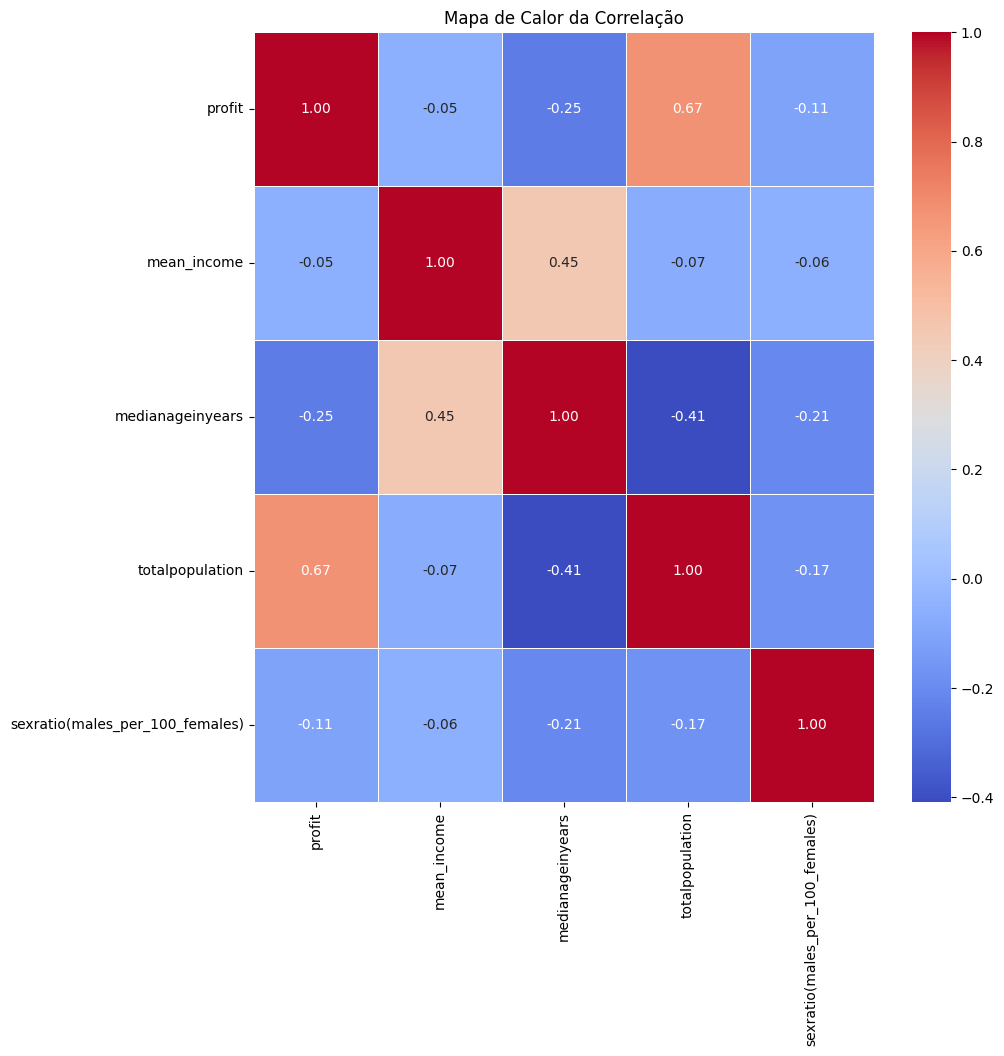

In [88]:
# Selecionando apenas as colunas que queremos analisar
# Essas colunas são: lucro, renda média, idade média, população total e proporção de homens para cada 100 mulheres
variaveis_selecionadas = geocode_df_silver[['profit', 'mean_income', 'medianageinyears','totalpopulation','sexratio(males_per_100_females)']]

# Calculando a correlação entre essas variáveis
# A correlação mostra se uma variável influencia ou tem relação com outra (por exemplo, se maior renda significa mais lucro)
matriz_correlacao1 = variaveis_selecionadas.corr()

# Criando um mapa visual com cores para facilitar a interpretação dos resultados
# Quanto mais próximo de 1 ou -1, mais forte a correlação. Próximo de 0, menos relação.
plt.figure(figsize=(10,10 ))
sns.heatmap(matriz_correlacao1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor da Correlação')
plt.show()


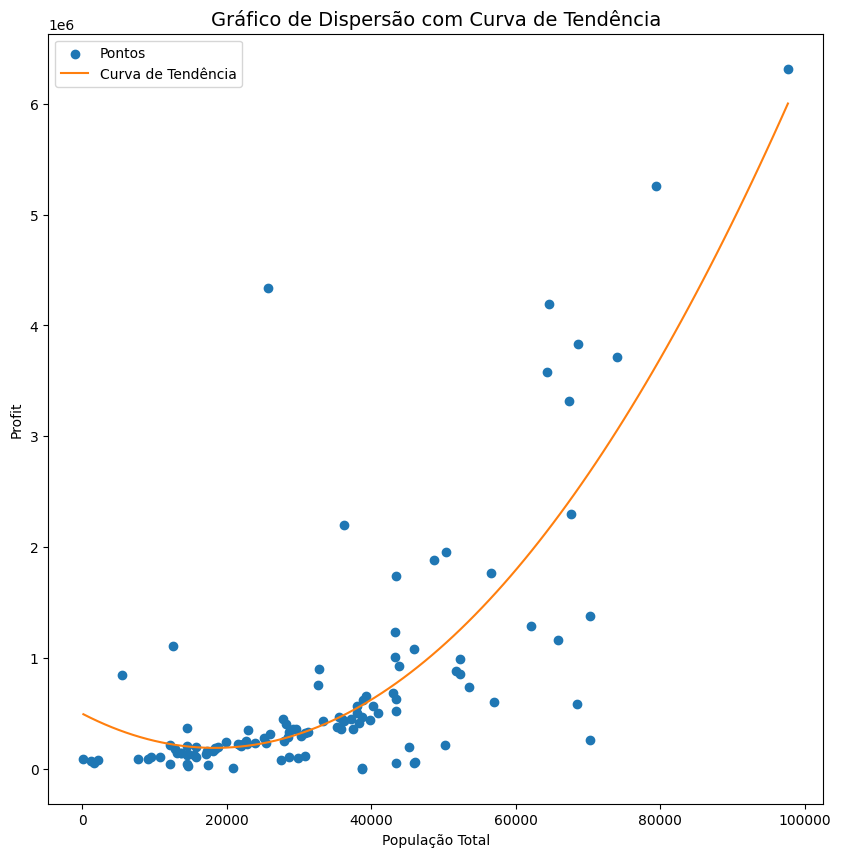

In [ ]:
# Seleciona os dados de população total e lucro
x = geocode_df_silver['totalpopulation']
y = geocode_df_silver['profit']

# Remove entradas com valores ausentes (NaN) ou infinitos
valid_entries = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x = x[valid_entries]
y = y[valid_entries]

# Ajusta uma curva polinomial (grau 2)
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Cria o gráfico de dispersão com nova cor (ex: azul-escuro)
plt.figure(figsize=(10,10))
plt.scatter(x, y, color='#1f77b4', label='Pontos')  # cor azul escuro

# Cria e plota a curva de tendência com uma nova cor (ex: laranja)
x_curve = np.linspace(min(x), max(x), 100)
plt.plot(x_curve, polynomial(x_curve), color='#ff7f0e', label='Curva de Tendência')  # laranja

# Título e eixos
plt.title('Gráfico de Dispersão com Curva de Tendência', fontsize=14)
plt.xlabel('População Total')
plt.ylabel('Profit')

# Adiciona a legenda
plt.legend()

# Exibe o gráfico
plt.show()


Com base no mapa de calor da correlação, podemos observar que:

Há uma forte correlação positiva entre o total da população e o lucro, indicando que áreas mais populosas tendem a gerar maiores lucros.

A relação entre o lucro e a razão de sexo (homens por 100 mulheres) é negativa, o que sugere que locais com uma proporção ligeiramente maior de mulheres podem estar associados a lucros mais elevados.

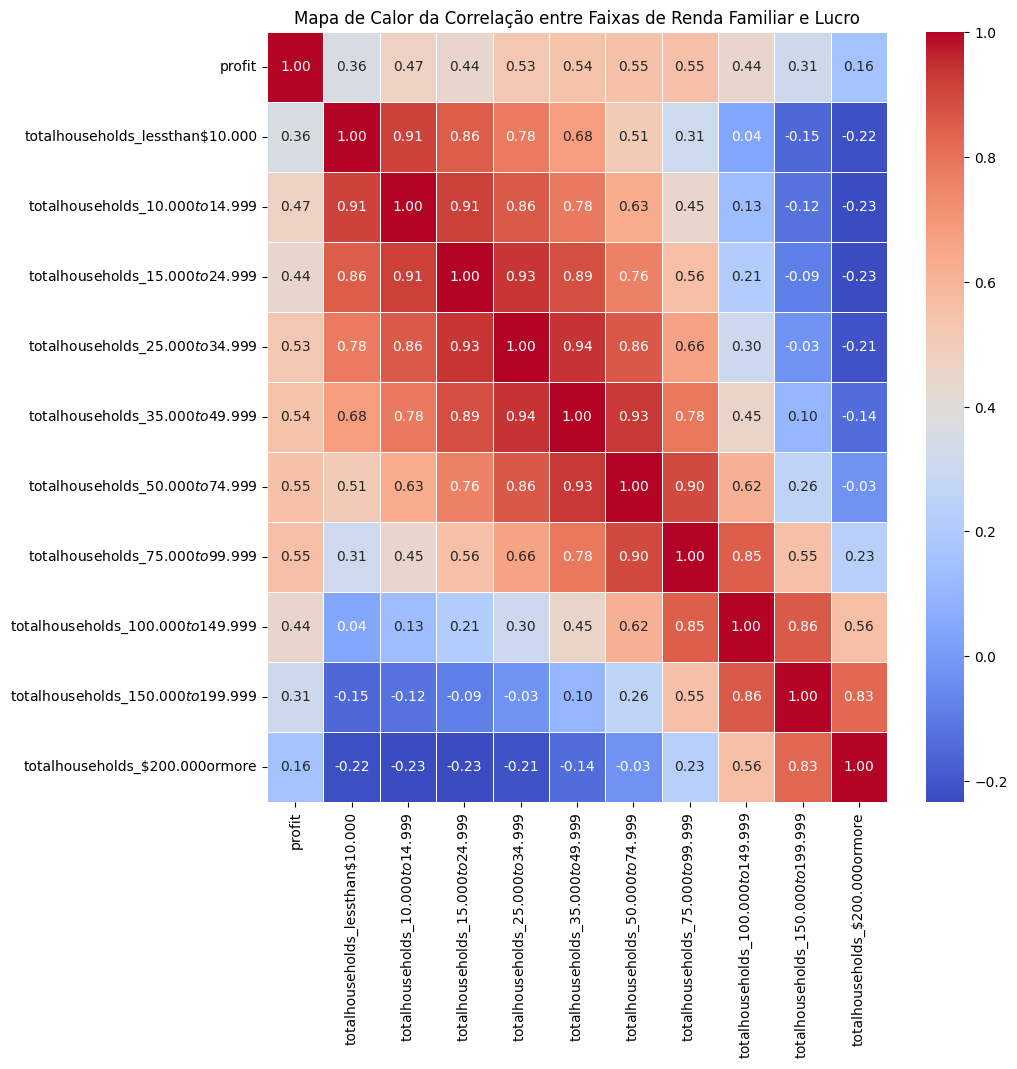

In [94]:
# Seleciona as variáveis de interesse para analisar a correlação com o lucro,
# neste caso, os diferentes intervalos de renda familiar
variaveis_selecionadas = geocode_df_silver[[
    'profit',
    'totalhouseholds_lessthan$10.000',
    'totalhouseholds_$10.000to$14.999',
    'totalhouseholds_$15.000to$24.999',
    'totalhouseholds_$25.000to$34.999',
    'totalhouseholds_$35.000to$49.999',
    'totalhouseholds_$50.000to$74.999',
    'totalhouseholds_$75.000to$99.999',
    'totalhouseholds_$100.000to$149.999',
    'totalhouseholds_$150.000to$199.999',
    'totalhouseholds_$200.000ormore'
]]

# Calcula a matriz de correlação entre essas variáveis
matriz_correlacao2 = variaveis_selecionadas.corr()

# Cria uma figura para visualizar a correlação usando um mapa de calor (heatmap)
plt.figure(figsize=(10,10))

# Gera o heatmap com as correlações, onde:
# - 'annot=True' exibe os valores nas células
# - 'cmap' define o esquema de cores
# - 'fmt' formata os números com duas casas decimais
# - 'linewidths' define a espessura das linhas entre as células
sns.heatmap(matriz_correlacao2, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Adiciona um título ao gráfico
plt.title('Mapa de Calor da Correlação entre Faixas de Renda Familiar e Lucro')

# Exibe o gráfico na tela
plt.show()


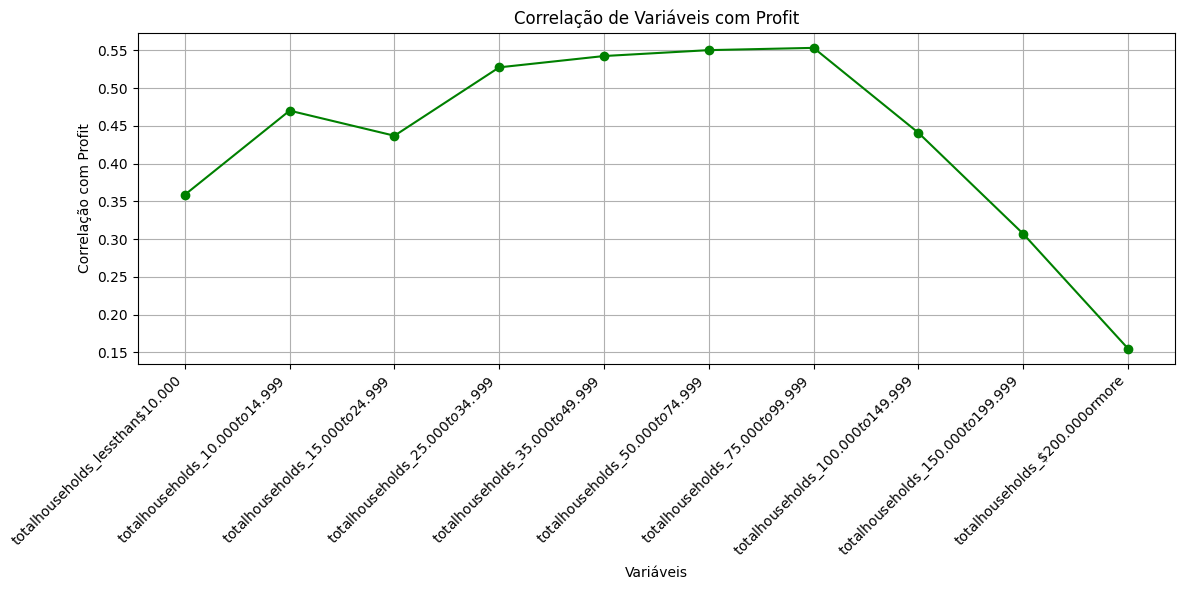

In [95]:
# Obtenha as correlações da primeira linha (exceto a correlação com 'profit' que é 1)
correlations = matriz_correlacao2.iloc[0, 1:]

# Obtenha o nome das variáveis
variables = correlations.index

# Crie um gráfico de linha
plt.figure(figsize=(12, 6))
# Altere a cor da linha para verde (color='green' ou 'g')
plt.plot(variables, correlations, marker='o', linestyle='-', color='green')

# Adicione rótulos e título
plt.xlabel('Variáveis')
plt.ylabel('Correlação com Profit')
plt.title('Correlação de Variáveis com Profit')

# Adicione grade
plt.grid(True)

# Rotacione os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Ajuste o layout para melhor visualização
plt.tight_layout()

# Exiba o gráfico
plt.show()


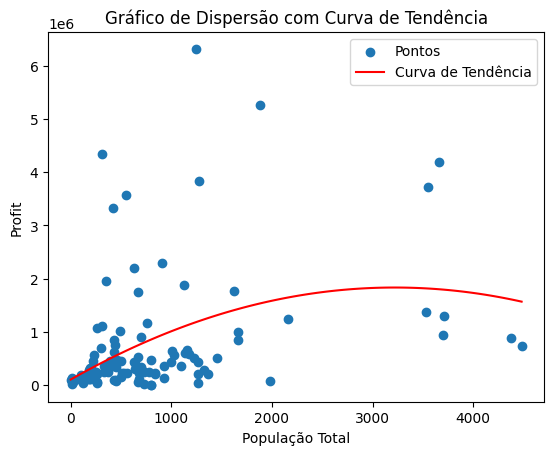

In [104]:

x = geocode_df_silver['totalhouseholds_lessthan$10.000']
y = geocode_df_silver['profit']

# Remover linhas com valores nulos ou infinitos
valid_entries = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x = x[valid_entries]
y = y[valid_entries]

# Ajustar um polinômio de grau 2 (curva quadrática)
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Criar um gráfico de dispersão
plt.scatter(x, y, label='Pontos')

# Gerar valores de x para a curva
x_curve = np.linspace(min(x), max(x), 100)
# Adicionar a curva de tendência
plt.plot(x_curve, polynomial(x_curve), color='red', label='Curva de Tendência')

# Configurar rótulos e título
plt.title('Gráfico de Dispersão com Curva de Tendência')
plt.xlabel('População Total')
plt.ylabel('Profit')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

A partir dos gráficos, observa-se que a faixa de renda considerada mais favorável está entre 25 mil e 100 mil. Dentro desse intervalo, especialmente entre 75 mil e 100 mil, os resultados se mantêm estáveis e positivos. Por outro lado, rendas acima de 150 mil tendem a apresentar os piores desempenhos em relação ao lucro.

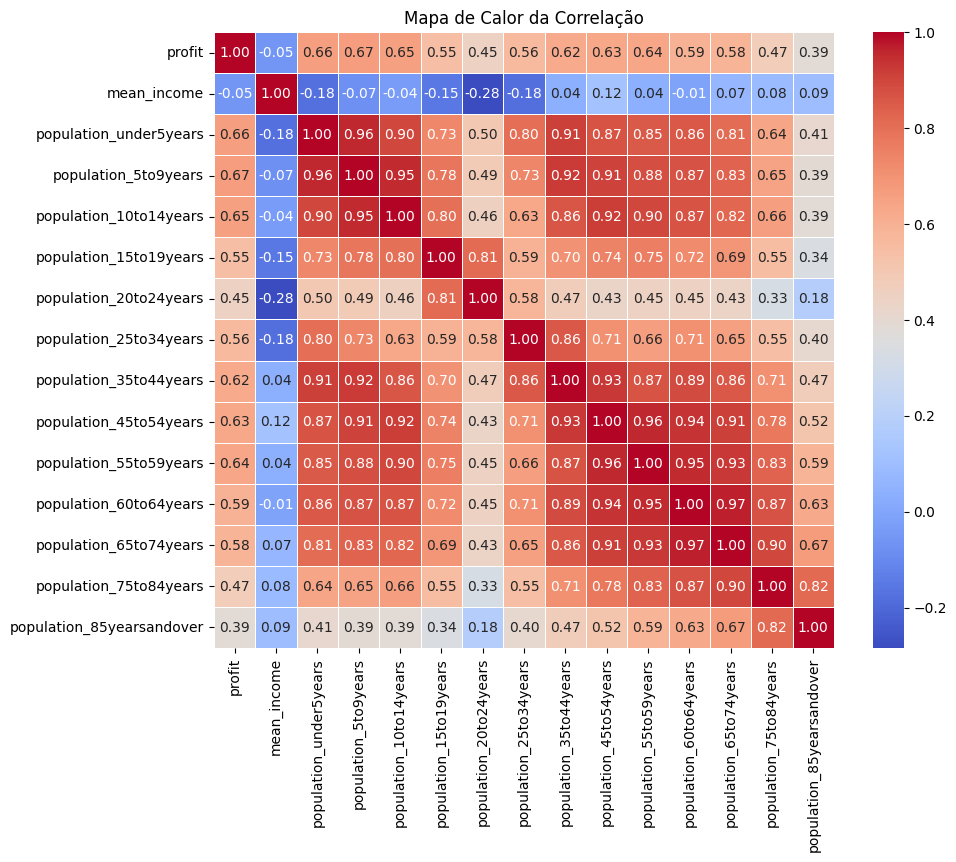

In [100]:
variaveis_selecionadas = geocode_df_silver[['profit', 'mean_income','population_under5years','population_5to9years','population_10to14years','population_15to19years','population_20to24years','population_25to34years','population_35to44years','population_45to54years','population_55to59years','population_60to64years','population_65to74years','population_75to84years','population_85yearsandover']]
matriz_correlacao3 = variaveis_selecionadas.corr()

# Crie um mapa de calor usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao3, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor da Correlação')
plt.show()

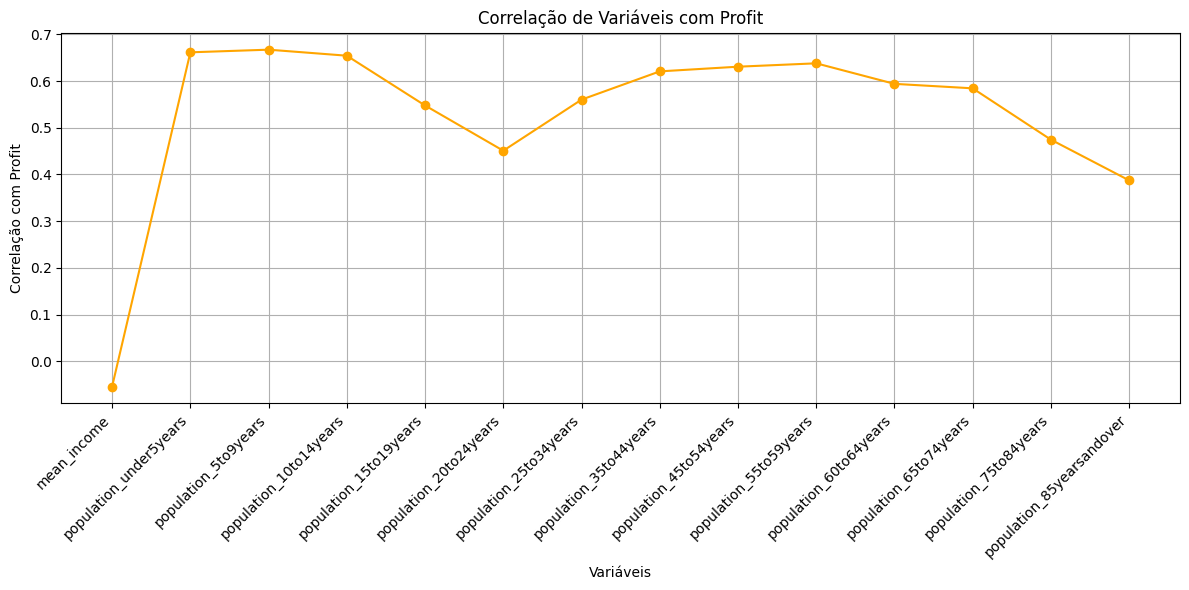

In [101]:
# Obtenha as correlações da primeira linha (exceto a correlação com 'profit' que é 1)
correlations = matriz_correlacao3.iloc[0, 1:]

# Obtenha o nome das variáveis
variables = correlations.index

# Crie um gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(variables, correlations, marker='o', linestyle='-', color='orange')  # Cor alterada para laranja

# Adicione rótulos e título
plt.xlabel('Variáveis')
plt.ylabel('Correlação com Profit')
plt.title('Correlação de Variáveis com Profit')

# Adicione grade
plt.grid(True)

# Rotacione os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Exiba o gráfico
plt.tight_layout()
plt.show()


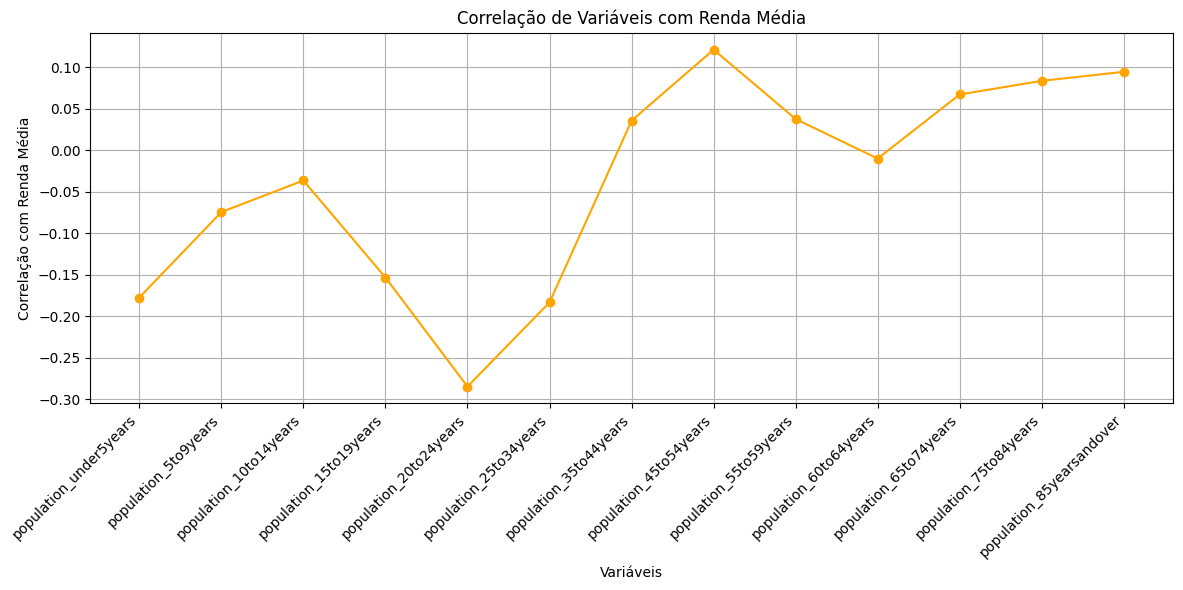

In [103]:
# Obtenha as correlações da primeira linha (exceto a correlação com 'profit' que é 1)
correlations = matriz_correlacao3.iloc[1, 2:]

# Obtenha o nome das variáveis
variables = correlations.index

# Crie um gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(variables, correlations, marker='o', linestyle='-', color='orange')  # Linha e marcadores em laranja

# Adicione rótulos e título
plt.xlabel('Variáveis')
plt.ylabel('Correlação com Renda Média')
plt.title('Correlação de Variáveis com Renda Média')

# Adicione grade
plt.grid(True)

# Rotacione os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right')

# Exiba o gráfico
plt.tight_layout()
plt.show()


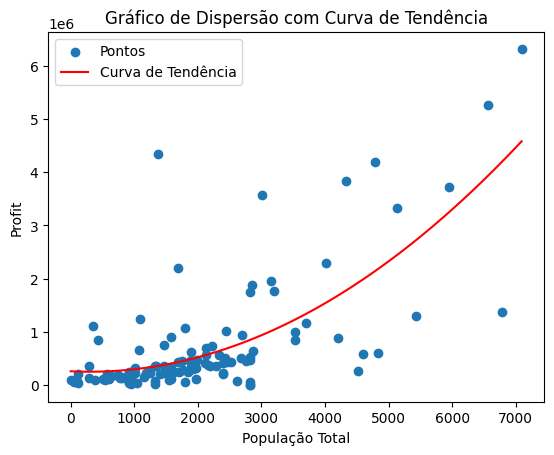

In [105]:

x = geocode_df_silver['population_under5years']
y = geocode_df_silver['profit']

# Remover linhas com valores nulos ou infinitos
valid_entries = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x = x[valid_entries]
y = y[valid_entries]

# Ajustar um polinômio de grau 2 (curva quadrática)
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Criar um gráfico de dispersão
plt.scatter(x, y, label='Pontos')

# Gerar valores de x para a curva
x_curve = np.linspace(min(x), max(x), 100)
# Adicionar a curva de tendência
plt.plot(x_curve, polynomial(x_curve), color='red', label='Curva de Tendência')

# Configurar rótulos e título
plt.title('Gráfico de Dispersão com Curva de Tendência')
plt.xlabel('População Total')
plt.ylabel('Profit')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

Com base nos gráficos demográficos, é possível observar que:

- As faixas etárias que mais se destacam positivamente em relação ao lucro são as de crianças até 14 anos e adultos entre 35 e 60 anos.  
- Por outro lado, os menores desempenhos estão associados aos jovens adultos entre 15 e 35 anos e aos idosos com mais de 75 anos.


A partir dessas análises, é possível definir o público-alvo ideal:

- Indivíduos nas faixas etárias de 0 a 14 anos e de 35 a 60 anos;  
- Famílias com renda entre R$25.000 e R$100.000 anuais;  
- Regiões com maior densidade populacional tendem a gerar mais lucro;  
- Uma leve predominância feminina na população é considerada favorável.


Agora, vou criar dois novos DataFrames: um com foco demográfico e outro com foco econômico.

O DataFrame demográfico será ordenado com base no total da população pertencente às faixas etárias identificadas como mais lucrativas.  

O DataFrame econômico será ordenado com base no total de famílias com renda entre R$25.000 e R$100.000 anuais.  

Em seguida, vou cruzar os rankings dos dois DataFrames, eliminar as localidades que já possuem laboratório e selecionar as três regiões mais promissoras.

In [106]:
candidatos_eco_df = economic_df
candidatos_demo_df = demo_df

In [107]:
candidatos_demo_df = demo_df

In [108]:
candidatos_eco_df.head()

,unnamed:_0,id,geographic_area_name,totalhouseholds_lessthan$10.000,totalhouseholds_$10.000to$14.999,totalhouseholds_$15.000to$24.999,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,totalhouseholds_$100.000to$149.999,totalhouseholds_$150.000to$199.999,totalhouseholds_$200.000ormore,zip_code
0,0,8600000US35004,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61,35004
1,1,8600000US35005,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26,35005
2,2,8600000US35006,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7,35006
3,3,8600000US35007,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254,35007
4,4,8600000US35010,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249,35010


In [109]:

candidatos_eco_df.drop('totalhouseholds_lessthan$10.000', axis=1, inplace=True)
candidatos_eco_df.drop('totalhouseholds_$10.000to$14.999', axis=1, inplace=True)
candidatos_eco_df.drop('totalhouseholds_$15.000to$24.999', axis=1, inplace=True)
candidatos_eco_df.drop('totalhouseholds_$100.000to$149.999', axis=1, inplace=True)
candidatos_eco_df.drop('totalhouseholds_$150.000to$199.999', axis=1, inplace=True)
candidatos_eco_df.drop('totalhouseholds_$200.000ormore', axis=1, inplace=True)

In [110]:
candidatos_eco_df.head()

,unnamed:_0,id,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,zip_code
0,0,8600000US35004,ZCTA5 35004,513,647,1117,529,35004
1,1,8600000US35005,ZCTA5 35005,293,353,562,299,35005
2,2,8600000US35006,ZCTA5 35006,104,154,176,124,35006
3,3,8600000US35007,ZCTA5 35007,462,1173,1854,1578,35007
4,4,8600000US35010,ZCTA5 35010,957,1056,1512,807,35010


In [111]:
candidatos_eco_df['populacao_alvo'] = candidatos_eco_df[['totalhouseholds_$25.000to$34.999', 'totalhouseholds_$35.000to$49.999', 'totalhouseholds_$50.000to$74.999', 'totalhouseholds_$75.000to$99.999']].sum(axis=1)
candidatos_eco_df = candidatos_eco_df.sort_values('populacao_alvo', ascending=False)
candidatos_eco_df = candidatos_eco_df.drop_duplicates(subset='geographic_area_name')
candidatos_eco_df.head(30)


,unnamed:_0,id,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,zip_code,populacao_alvo
225453,225453,8600000US37013,ZCTA5 37013,3332,5433,8466,5507,37013,22738
426731,426731,8600000US79936,ZCTA5 79936,3597,5988,7624,4704,79936,21913
293298,293298,8600000US77449,ZCTA5 77449,2596,4315,7438,6491,77449,20840
28236,28236,8600000US77084,ZCTA5 77084,3349,4939,7049,5358,77084,20695
317187,317187,8600000US11226,ZCTA5 11226,3758,4492,6777,5290,11226,20317
335839,335839,8600000US32162,ZCTA5 32162,2323,4909,7107,5500,32162,19839
350114,350114,8600000US10467,ZCTA5 10467,4249,5519,6498,3263,10467,19529
192356,192356,8600000US37042,ZCTA5 37042,3908,4687,6378,3936,37042,18909
424958,424958,8600000US75287,ZCTA5 75287,2925,5943,6731,2806,75287,18405
383466,383466,8600000US11385,ZCTA5 11385,2752,3682,6058,5811,11385,18303


In [112]:
candidatos_eco_df_pronto = candidatos_eco_df

In [113]:
candidatos_demo_df.head()

,unnamed:_0,id,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_15to19years,population_20to24years,population_25to34years,population_35to44years,population_45to54years,population_55to59years,population_60to64years,population_65to74years,population_75to84years,population_85yearsandover,medianageinyears,zip_code
0,0,8600000US35004,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5,35004
1,1,8600000US35005,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0,35005
2,2,8600000US35006,ZCTA5 35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2,35006
3,3,8600000US35007,ZCTA5 35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7,35007
4,4,8600000US35010,ZCTA5 35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6,35010


In [114]:
candidatos_demo_df.drop('population_15to19years', axis=1, inplace=True)
candidatos_demo_df.drop('population_20to24years', axis=1, inplace=True)
candidatos_demo_df.drop('population_25to34years', axis=1, inplace=True)
candidatos_demo_df.drop('population_60to64years', axis=1, inplace=True)
candidatos_demo_df.drop('population_65to74years', axis=1, inplace=True)
candidatos_demo_df.drop('population_75to84years', axis=1, inplace=True)
candidatos_demo_df.drop('population_85yearsandover', axis=1, inplace=True)

In [115]:
candidatos_demo_df['populacao_alvo'] = candidatos_demo_df[['population_under5years', 'population_5to9years', 'population_10to14years', 'population_35to44years','population_45to54years','population_55to59years']].sum(axis=1)
candidatos_demo_df = candidatos_demo_df.sort_values('populacao_alvo', ascending=False)
candidatos_demo_df = candidatos_demo_df.drop_duplicates(subset='geographicareaname')
candidatos_demo_df.head(30)

,unnamed:_0,id,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,population_55to59years,medianageinyears,zip_code,populacao_alvo
28375,28375,8600000US77494,ZCTA5 77494,118291,93.7,8929,11394,12285,23166,18058,5118,35.2,77494,78950
28338,28338,8600000US77449,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,6077,31.7,77449,78783
27375,27375,8600000US75034,ZCTA5 75034,108525,95.3,6533,8759,10586,18751,17630,5697,36.8,75034,67956
27400,27400,8600000US75070,ZCTA5 75070,104415,91.8,8029,8976,8850,19131,16093,5379,37.1,75070,66458
1885,1885,8600000US90011,ZCTA5 90011,111165,102.3,9263,10092,10008,15873,13603,4566,28.7,90011,63405
19135,19135,8600000US11368,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,5156,32.9,11368,63156
18364,18364,8600000US08701,ZCTA5 08701,102466,98.9,17564,14784,12176,9973,5772,2270,19.3,08701,62539
28236,28236,8600000US77084,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,5629,33.1,77084,61027
28324,28324,8600000US77433,ZCTA5 77433,90657,100.8,8062,8749,9384,16310,12113,4796,32.9,77433,59414
6960,6960,8600000US60629,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,5492,31.2,60629,58628


In [116]:
candidatos_demo_df_pronto = candidatos_demo_df


In [117]:
candidatos_demo_df_pronto = candidatos_demo_df_pronto.head(30)
candidatos_eco_df_pronto = candidatos_eco_df_pronto.head(30)

In [118]:
candidatos_demo_df_pronto

,unnamed:_0,id,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,population_55to59years,medianageinyears,zip_code,populacao_alvo
28375,28375,8600000US77494,ZCTA5 77494,118291,93.7,8929,11394,12285,23166,18058,5118,35.2,77494,78950
28338,28338,8600000US77449,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,6077,31.7,77449,78783
27375,27375,8600000US75034,ZCTA5 75034,108525,95.3,6533,8759,10586,18751,17630,5697,36.8,75034,67956
27400,27400,8600000US75070,ZCTA5 75070,104415,91.8,8029,8976,8850,19131,16093,5379,37.1,75070,66458
1885,1885,8600000US90011,ZCTA5 90011,111165,102.3,9263,10092,10008,15873,13603,4566,28.7,90011,63405
19135,19135,8600000US11368,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,5156,32.9,11368,63156
18364,18364,8600000US08701,ZCTA5 08701,102466,98.9,17564,14784,12176,9973,5772,2270,19.3,08701,62539
28236,28236,8600000US77084,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,5629,33.1,77084,61027
28324,28324,8600000US77433,ZCTA5 77433,90657,100.8,8062,8749,9384,16310,12113,4796,32.9,77433,59414
6960,6960,8600000US60629,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,5492,31.2,60629,58628


In [119]:
eco_demo_df = pd.merge(candidatos_demo_df_pronto, candidatos_eco_df_pronto, on='zip_code', how='inner')


In [120]:
eco_demo_df

,unnamed:_0_x,id_x,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,...,zip_code,populacao_alvo_x,unnamed:_0_y,id_y,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,populacao_alvo_y
0,28338,8600000US77449,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,...,77449,78783,293298,8600000US77449,ZCTA5 77449,2596,4315,7438,6491,20840
1,19135,8600000US11368,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,...,11368,63156,482815,8600000US11368,ZCTA5 11368,2901,4287,5514,4211,16913
2,28236,8600000US77084,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,...,77084,61027,28236,8600000US77084,ZCTA5 77084,3349,4939,7049,5358,20695
3,6960,8600000US60629,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,...,60629,58628,139440,8600000US60629,ZCTA5 60629,4130,5022,5651,2944,17747
4,19146,8600000US11385,ZCTA5 11385,107796,98.8,6994,6595,7054,16015,14852,...,11385,58055,383466,8600000US11385,ZCTA5 11385,2752,3682,6058,5811,18303
5,29291,8600000US79936,ZCTA5 79936,111620,96.3,6549,7949,8723,13111,14345,...,79936,57771,426731,8600000US79936,ZCTA5 79936,3597,5988,7624,4704,21913
6,19089,8600000US11208,ZCTA5 11208,101313,88.0,8811,7596,7326,12913,12625,...,11208,55611,284049,8600000US11208,ZCTA5 11208,3247,4509,5032,3795,16583
7,26733,8600000US37013,ZCTA5 37013,97939,94.8,8566,7447,6855,14718,12157,...,37013,54788,225453,8600000US37013,ZCTA5 37013,3332,5433,8466,5507,22738
8,18914,8600000US10467,ZCTA5 10467,101255,90.1,8204,6810,6969,13823,12710,...,10467,54194,350114,8600000US10467,ZCTA5 10467,4249,5519,6498,3263,19529
9,1960,8600000US90250,ZCTA5 90250,97072,96.0,7766,7083,6310,13829,13360,...,90250,53577,598120,8600000US90250,ZCTA5 90250,3063,4164,6678,3967,17872


In [121]:
merged_df = pd.merge(eco_demo_df, geocode_df_silver[['zip_code']], on='zip_code', how='left', indicator=True)

# Mantém apenas as linhas que não estão presentes em geocode_df_silver
final_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])


In [122]:
final_df

,unnamed:_0_x,id_x,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,...,zip_code,populacao_alvo_x,unnamed:_0_y,id_y,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,populacao_alvo_y
0,28338,8600000US77449,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,...,77449,78783,293298,8600000US77449,ZCTA5 77449,2596,4315,7438,6491,20840
1,19135,8600000US11368,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,...,11368,63156,482815,8600000US11368,ZCTA5 11368,2901,4287,5514,4211,16913
2,28236,8600000US77084,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,...,77084,61027,28236,8600000US77084,ZCTA5 77084,3349,4939,7049,5358,20695
3,6960,8600000US60629,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,...,60629,58628,139440,8600000US60629,ZCTA5 60629,4130,5022,5651,2944,17747
4,19146,8600000US11385,ZCTA5 11385,107796,98.8,6994,6595,7054,16015,14852,...,11385,58055,383466,8600000US11385,ZCTA5 11385,2752,3682,6058,5811,18303
5,29291,8600000US79936,ZCTA5 79936,111620,96.3,6549,7949,8723,13111,14345,...,79936,57771,426731,8600000US79936,ZCTA5 79936,3597,5988,7624,4704,21913
6,19089,8600000US11208,ZCTA5 11208,101313,88.0,8811,7596,7326,12913,12625,...,11208,55611,284049,8600000US11208,ZCTA5 11208,3247,4509,5032,3795,16583
7,26733,8600000US37013,ZCTA5 37013,97939,94.8,8566,7447,6855,14718,12157,...,37013,54788,225453,8600000US37013,ZCTA5 37013,3332,5433,8466,5507,22738
8,18914,8600000US10467,ZCTA5 10467,101255,90.1,8204,6810,6969,13823,12710,...,10467,54194,350114,8600000US10467,ZCTA5 10467,4249,5519,6498,3263,19529
9,1960,8600000US90250,ZCTA5 90250,97072,96.0,7766,7083,6310,13829,13360,...,90250,53577,598120,8600000US90250,ZCTA5 90250,3063,4164,6678,3967,17872


O final_df contém apenas 10 localidades. Posso usar o critério de população como fator de desempate, mas, antes disso, quero visualizar esses pontos no mapa para entender melhor sua distribuição geográfica.

In [123]:
print(final_df)

   unnamed:_0_x            id_x geographicareaname  totalpopulation  \
0         28338  8600000US77449        ZCTA5 77449           128294   
1         19135  8600000US11368        ZCTA5 11368           112088   
2         28236  8600000US77084        ZCTA5 77084           107673   
3          6960  8600000US60629        ZCTA5 60629           110029   
4         19146  8600000US11385        ZCTA5 11385           107796   
5         29291  8600000US79936        ZCTA5 79936           111620   
6         19089  8600000US11208        ZCTA5 11208           101313   
7         26733  8600000US37013        ZCTA5 37013            97939   
8         18914  8600000US10467        ZCTA5 10467           101255   
9          1960  8600000US90250        ZCTA5 90250            97072   

   sexratio(males_per_100_females)  population_under5years  \
0                             91.5                   10192   
1                            109.4                   10107   
2                             95

In [125]:


# Supondo que 'lab_id' seja uma coluna que identifica exclusivamente as franquias
geocode_df_silver['franchise_status'] = 'existing'
final_df['franchise_status'] = 'candidate'

# Adicionando a coluna 'marker_color' com base no status da franquia
geocode_df_silver['marker_color'] = 'red'
final_df['marker_color'] = 'blue'

# Convertendo as coordenadas para números nas franquias existentes
geocode_df_silver[['latitude', 'longitude']] = geocode_df_silver['location'].str.split(',', expand=True).astype(float)

# Geocodificando os códigos postais das franquias candidatas
geolocator = Nominatim(user_agent="geo_locator")

for i, row in final_df.iterrows():
    location = geolocator.geocode(row['zip_code'])
    if location:
        final_df.at[i, 'latitude'] = location.latitude
        final_df.at[i, 'longitude'] = location.longitude

# Concatenar os DataFrames das franquias existentes com as coordenadas das candidatas
geocode_df_combined = pd.concat([geocode_df_silver[['franchise_status', 'marker_color', 'latitude', 'longitude', 'zip_code']],
                                 final_df[['franchise_status', 'marker_color', 'latitude', 'longitude','zip_code']]],
                                ignore_index=True)

# Criando um mapa centrado nas coordenadas médias
map_center = [geocode_df_combined['latitude'].mean(), geocode_df_combined['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)

# Adicionando marcadores ao mapa
# Adicionando marcadores ao mapa
for i, row in geocode_df_combined.iterrows():
    location = (row['latitude'], row['longitude'])
    
    popup_text = f"{row['zip_code']}"
    if 'lab_id' in row:
        popup_text += f" - {row['lab_id']} - {row.get('address', '')}"

    folium.Marker(
        location=location,
        popup=popup_text,
        icon=folium.Icon(color=row['marker_color'])
    ).add_to(mymap)

# Exibindo o mapa
mymap

In [126]:
geocode_df_combined.tail(10)

,franchise_status,marker_color,latitude,longitude,zip_code
118,candidate,blue,29.818634,-95.739789,77449
119,candidate,blue,36.210603,-5.391249,11368
120,candidate,blue,18.520651,-88.320808,77084
121,candidate,blue,41.781426,-87.706516,60629
122,candidate,blue,40.703903,-73.892619,11385
123,candidate,blue,31.752781,-106.295994,79936
124,candidate,blue,54.688403,25.417228,11208
125,candidate,blue,45.602050,10.792546,37013
126,candidate,blue,37.663210,126.845118,10467
127,candidate,blue,48.152874,22.629366,90250


In [127]:
# 77084

geocode_df_combined.at[120, 'latitude'] = 29.82698
geocode_df_combined.at[120, 'longitude'] = -95.6612

In [128]:
# 11368

geocode_df_combined.at[119, 'latitude'] = 40.74962
geocode_df_combined.at[119, 'longitude'] = -73.85264

In [129]:
# 37013

geocode_df_combined.at[125, 'latitude'] = 36.04658
geocode_df_combined.at[125, 'longitude'] = -86.63445

In [130]:
# 90250

geocode_df_combined.at[127, 'latitude'] = 33.91383
geocode_df_combined.at[127, 'longitude'] = -118.34996

In [131]:
# 10467

geocode_df_combined.at[126, 'latitude'] = 40.87522
geocode_df_combined.at[126, 'longitude'] = -73.872

In [133]:
for i, row in final_df.iterrows():
    # Verificar se a geocodificação já foi feita (latitude e longitude não são NaN)
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        # Se não for a primeira rodada, use as coordenadas adicionadas manualmente
        final_df.at[i, 'latitude'] = row['latitude']
        final_df.at[i, 'longitude'] = row['longitude']

# ...

# Criando um mapa centrado nas coordenadas médias
map_center = [geocode_df_combined['latitude'].mean(), geocode_df_combined['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)

# Adicionando marcadores ao mapa
for i, row in geocode_df_combined.iterrows():
    location = (row['latitude'], row['longitude'])
    
    popup_text = f"{row['zip_code']}"
    if 'lab_id' in row:
        popup_text += f" - {row['lab_id']} - {row.get('address', '')}"

    folium.Marker(
        location=location,
        popup=popup_text,
        icon=folium.Icon(color=row['marker_color'])
    ).add_to(mymap)

# Exibindo o mapa
mymap

In [134]:
final_df

,unnamed:_0_x,id_x,geographicareaname,totalpopulation,sexratio(males_per_100_females),population_under5years,population_5to9years,population_10to14years,population_35to44years,population_45to54years,...,geographic_area_name,totalhouseholds_$25.000to$34.999,totalhouseholds_$35.000to$49.999,totalhouseholds_$50.000to$74.999,totalhouseholds_$75.000to$99.999,populacao_alvo_y,franchise_status,marker_color,latitude,longitude
0,28338,8600000US77449,ZCTA5 77449,128294,91.5,10192,11515,12289,21261,17449,...,ZCTA5 77449,2596,4315,7438,6491,20840,candidate,blue,29.818634,-95.739789
1,19135,8600000US11368,ZCTA5 11368,112088,109.4,10107,8092,7766,18627,13408,...,ZCTA5 11368,2901,4287,5514,4211,16913,candidate,blue,36.210603,-5.391249
2,28236,8600000US77084,ZCTA5 77084,107673,95.0,7892,7653,9496,16232,14125,...,ZCTA5 77084,3349,4939,7049,5358,20695,candidate,blue,18.520651,-88.320808
3,6960,8600000US60629,ZCTA5 60629,110029,95.8,8901,7683,9135,14369,13048,...,ZCTA5 60629,4130,5022,5651,2944,17747,candidate,blue,41.781426,-87.706516
4,19146,8600000US11385,ZCTA5 11385,107796,98.8,6994,6595,7054,16015,14852,...,ZCTA5 11385,2752,3682,6058,5811,18303,candidate,blue,40.703903,-73.892619
5,29291,8600000US79936,ZCTA5 79936,111620,96.3,6549,7949,8723,13111,14345,...,ZCTA5 79936,3597,5988,7624,4704,21913,candidate,blue,31.752781,-106.295994
6,19089,8600000US11208,ZCTA5 11208,101313,88.0,8811,7596,7326,12913,12625,...,ZCTA5 11208,3247,4509,5032,3795,16583,candidate,blue,54.688403,25.417228
7,26733,8600000US37013,ZCTA5 37013,97939,94.8,8566,7447,6855,14718,12157,...,ZCTA5 37013,3332,5433,8466,5507,22738,candidate,blue,45.602050,10.792546
8,18914,8600000US10467,ZCTA5 10467,101255,90.1,8204,6810,6969,13823,12710,...,ZCTA5 10467,4249,5519,6498,3263,19529,candidate,blue,37.663210,126.845118
9,1960,8600000US90250,ZCTA5 90250,97072,96.0,7766,7083,6310,13829,13360,...,ZCTA5 90250,3063,4164,6678,3967,17872,candidate,blue,48.152874,22.629366


No mapa acima, os locais em vermelho indicam onde já existem unidades do laboratório. Os pontos em azul representam os 10 melhores candidatos, selecionados com base nos critérios demográficos e econômicos.

A cidade de Houston, no Texas, apresentou dois pontos muito próximos um do outro. Isso sugere que, escolhendo um endereço estratégico próximo à divisa entre esses dois ZIP codes, é possível atender a ambas as populações e maximizar o alcance da nova unidade.

O ZIP code **77449** destacou-se por apresentar os melhores indicadores em termos de demografia e renda familiar entre todos os candidatos, sendo, portanto, uma das minhas escolhas prioritárias.

Já a cidade de Nova York teve quatro pontos identificados. Entre eles, o ZIP code **11368** inicialmente chamou atenção pelos números, mas ao observar o mapa, percebe-se que ele está mais afastado dos demais candidatos. Além disso, a proporção entre homens e mulheres nesse local não é favorável.

Conforme identificado no primeiro mapa de calor, uma proporção mais elevada de mulheres tende a ser mais benéfica para os lucros. Por isso, o ponto **11385** se mostra mais promissor: ele reúne os dois melhores indicadores entre os candidatos de Nova York e ainda está relativamente próximo dos ZIP codes **11368** e **11208**.

Essa proximidade permite, mais uma vez, atingir populações de áreas vizinhas ao instalar uma unidade estrategicamente posicionada. Assim, minha escolha para Nova York é o ZIP code **11385**.

In [135]:

final_df = final_df.drop([0, 1, 2, 4, 6, 8])

In [136]:
print(final_df[['geographicareaname', 'totalpopulation', 'populacao_alvo_y', 'populacao_alvo_x']])


  geographicareaname  totalpopulation  populacao_alvo_y  populacao_alvo_x
3        ZCTA5 60629           110029             17747             58628
5        ZCTA5 79936           111620             21913             57771
7        ZCTA5 37013            97939             22738             54788
9        ZCTA5 90250            97072             17872             53577


Por fim, ao analisar os últimos quatro ZIP codes:

**60629** se destaca por possuir a maior população entre os quatro analisados, além do maior número de pessoas dentro da faixa etária considerada ideal (representada por `populacao_alvo_x`). No entanto, apresentou o pior desempenho em relação ao número de famílias dentro da faixa de renda desejada (representada por `populacao_alvo_y`).

O **90250** teve resultados insatisfatórios em todos os aspectos: população total, renda familiar e quantidade de pessoas na faixa etária ideal.

Restaram então os ZIP codes **79936** e **37013**, ambos com números consistentes tanto em renda familiar quanto na população dentro da faixa etária-alvo. 

Minha escolha final recai sobre o **79936**, que apresentou a maior população total entre os dois — fator que demonstrou a maior correlação positiva com a variável **lucro** ao longo da análise.


Com base na análise realizada, as minhas escolhas finais foram:

- **77449** – Houston, **Texas**  
- **11385** – New York, **Nova York**  
- **79936** – El Paso, **Texas**



In [137]:
geocode_df_combined

,franchise_status,marker_color,latitude,longitude,zip_code
0,existing,red,34.000319,-84.162972,30096
1,existing,red,43.231133,-75.444536,13440
2,existing,red,47.716279,-122.183815,98034
3,existing,red,33.909388,-84.352910,30342
4,existing,red,40.930993,-90.943760,61469
...,...,...,...,...,...
123,candidate,blue,31.752781,-106.295994,79936
124,candidate,blue,54.688403,25.417228,11208
125,candidate,blue,36.046580,-86.634450,37013
126,candidate,blue,40.875220,-73.872000,10467


In [138]:
zip_codes_to_change = ['77449', '11385', '79936']
new_marker_color = 'green'

# Alterando os valores
geocode_df_combined.loc[geocode_df_combined['zip_code'].isin(zip_codes_to_change), 'marker_color'] = new_marker_color


In [139]:

geocode_df_combined = geocode_df_combined[geocode_df_combined['marker_color'] == 'green']


In [140]:
for i, row in geocode_df_combined.iterrows():
    # Verificar se a geocodificação já foi feita (latitude e longitude não são NaN)
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        # Se não for a primeira rodada, use as coordenadas adicionadas manualmente
        geocode_df_combined.at[i, 'latitude'] = row['latitude']
        geocode_df_combined.at[i, 'longitude'] = row['longitude']

# ...

# Criando um mapa centrado nas coordenadas médias
map_center = [geocode_df_combined['latitude'].mean(), geocode_df_combined['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)

# Adicionando marcadores ao mapa
for i, row in geocode_df_combined.iterrows():
    location = (row['latitude'], row['longitude'])
    
    popup_text = f"{row['zip_code']}"
    if 'lab_id' in row:
        popup_text += f" - {row['lab_id']} - {row.get('address', '')}"

    folium.Marker(
        location=location,
        popup=popup_text,
        icon=folium.Icon(color=row['marker_color'])
    ).add_to(mymap)

# Exibindo o mapa
mymap